In [26]:
"""
Sales Conversion Prediction with Fine-Tuned Embeddings - Clean Version
=====================================================================
Step-by-step experiments without excessive print statements.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# =============================================================================
# STEP 1: GENERATE SAMPLE SALES DATA
# =============================================================================

def step1_generate_sample_data():
    """Generate realistic sales conversation data"""
    
    converting_conversations = [
        "Customer: I'm really interested in your solution. It looks like exactly what we need. Sales Rep: That's wonderful! Let me show you how we can get started immediately. Customer: Perfect! What's the timeline for implementation? Sales Rep: We can begin next week. Customer: Excellent, let's move forward with this.",
        
        "Customer: This platform could solve our biggest challenges. Sales Rep: I'm glad you see the value. Our solution has helped companies like yours increase efficiency by 40%. Customer: That's impressive! The ROI projections look compelling. Sales Rep: When would you like to start the onboarding process? Customer: As soon as possible. Let's do this!",
        
        "Customer: I've been looking for something like this for months. Sales Rep: You're in the right place! Our tool is designed specifically for businesses facing your challenges. Customer: The demo was convincing. I'm ready to make a decision. Sales Rep: Fantastic! I'll prepare the contract today. Customer: Perfect, I'm excited to get started.",
        
        "Customer: Your solution addresses all our pain points perfectly. Sales Rep: I'm thrilled to hear that! Let me walk you through our implementation process. Customer: This timeline works great for us. What are the next steps? Sales Rep: I'll send over the agreement this afternoon. Customer: Wonderful! I'll review and sign it right away.",
        
        "Customer: The pricing is reasonable and the features are exactly what we need. Sales Rep: I'm so glad this fits your requirements and budget. Customer: Yes, this is a no-brainer for us. When can we get started? Sales Rep: We can begin onboarding immediately after contract signature. Customer: Perfect! Let's proceed with the purchase."
    ]
    
    non_converting_conversations = [
        "Customer: I'm just browsing and comparing different options right now. Sales Rep: I understand. Let me show you what makes us unique. Customer: It's interesting, but we're still in early research phase. Sales Rep: No problem, I'll follow up in a few months. Customer: That sounds good. We're not ready to make any decisions yet.",
        
        "Customer: The price seems quite high compared to our budget. Sales Rep: I understand your concern. We do offer flexible payment plans. Customer: Even with the payment plan, it's still a stretch for us this quarter. Sales Rep: Would you like me to check back next quarter? Customer: Yes, maybe our budget situation will be different then.",
        
        "Customer: This looks complex. I'm not sure our team can handle the implementation. Sales Rep: We provide comprehensive training and support throughout the process. Customer: I appreciate that, but I think this might be too advanced for our current needs. Sales Rep: I understand. Perhaps something simpler would be better. Customer: Yes, let me look at some basic alternatives first.",
        
        "Customer: I need to discuss this with my team first before making any decisions. Sales Rep: Of course! Would it help if I presented to your team? Customer: Maybe, but honestly we have other priorities right now. Sales Rep: I understand timing is important. Customer: Yes, let's reconnect in a few months when things settle down.",
        
        "Customer: We're evaluating several vendors and haven't made up our minds yet. Sales Rep: What factors are most important in your decision? Customer: Mainly cost and ease of implementation. This seems complicated and expensive. Sales Rep: I can work on both those concerns. Customer: Thanks, but I think we'll go with a simpler solution for now."
    ]
    
    # Create dataset with variations
    conversations = []
    labels = []
    
    # Add original conversations
    for conv in converting_conversations:
        conversations.append(conv)
        labels.append(1)
    
    for conv in non_converting_conversations:
        conversations.append(conv)
        labels.append(0)
    
    # Add variations
    additional_conversations = []
    additional_labels = []
    
    for i, (conv, label) in enumerate(zip(conversations, labels)):
        variations = [
            conv.replace("Customer:", "Client:"),
            conv.replace("Sales Rep:", "Rep:"),
            conv.replace("solution", "platform"),
            conv.replace("perfect", "excellent" if "perfect" in conv else "perfect")
        ]
        
        for var in variations[:2]:
            additional_conversations.append(var)
            additional_labels.append(label)
    
    # Combine all data
    all_conversations = conversations + additional_conversations
    all_labels = labels + additional_labels
    
    df = pd.DataFrame({
        'conversation': all_conversations,
        'converted': all_labels,
        'conversation_id': [f"conv_{i+1:03d}" for i in range(len(all_conversations))]
    })
    
    print(f"Generated {len(df)} conversations | Conversion rate: {df['converted'].mean():.1%}")
    return df

# =============================================================================
# STEP 2: EXPLORE THE DATA
# =============================================================================

def step2_explore_data(df):
    """Explore and analyze sales conversation data"""
    
    # Basic statistics
    df['word_count'] = df['conversation'].apply(lambda x: len(x.split()))
    df['char_count'] = df['conversation'].apply(len)
    
    converting = df[df['converted'] == 1]
    non_converting = df[df['converted'] == 0]
    
    # Analyze keywords
    positive_keywords = ['interested', 'perfect', 'great', 'excellent', 'ready', 'start', 'proceed']
    negative_keywords = ['expensive', 'budget', 'complex', 'difficult', 'maybe', 'think', 'later']
    
    def count_keywords(text, keywords):
        text_lower = text.lower()
        return sum(1 for keyword in keywords if keyword in text_lower)
    
    df['positive_signals'] = df['conversation'].apply(lambda x: count_keywords(x, positive_keywords))
    df['negative_signals'] = df['conversation'].apply(lambda x: count_keywords(x, negative_keywords))
    
    print(f"Dataset: {len(df)} conversations")
    print(f"Avg words - Converting: {converting['word_count'].mean():.1f} | Non-converting: {non_converting['word_count'].mean():.1f}")
    print(f"Positive signals - Converting: {converting['positive_signals'].mean():.2f} | Non-converting: {non_converting['positive_signals'].mean():.2f}")
    
    # Visualization
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    df['converted'].value_counts().plot(kind='bar', color=['lightcoral', 'lightgreen'])
    plt.title('Conversion Distribution')
    plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
    
    plt.subplot(1, 3, 2)
    df.boxplot(column='word_count', by='converted', ax=plt.gca())
    plt.title('Word Count by Conversion')
    plt.suptitle('')
    
    plt.subplot(1, 3, 3)
    conversion_data = [converting['positive_signals'].mean(), non_converting['positive_signals'].mean()]
    plt.bar(['Converting', 'Non-Converting'], conversion_data, color=['lightgreen', 'lightcoral'])
    plt.title('Average Positive Signals')
    
    plt.tight_layout()
    plt.show()
    
    return df

# =============================================================================
# STEP 3: CREATE BASIC EMBEDDINGS
# =============================================================================

def step3_create_embeddings(df):
    """Create embeddings using pre-trained model"""
    
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    conversations = df['conversation'].tolist()
    embeddings = model.encode(conversations, show_progress_bar=False)
    
    print(f"Generated embeddings: {embeddings.shape}")
    
    # Example similarity analysis
    converting_indices = df[df['converted'] == 1].index[:2].tolist()
    non_converting_index = df[df['converted'] == 0].index[0]
    
    similarity_same = cosine_similarity([embeddings[converting_indices[0]]], [embeddings[converting_indices[1]]])[0][0]
    similarity_diff = cosine_similarity([embeddings[converting_indices[0]]], [embeddings[non_converting_index]])[0][0]
    
    print(f"Similarity between converting conversations: {similarity_same:.3f}")
    print(f"Similarity between converting and non-converting: {similarity_diff:.3f}")
    
    return embeddings, model

# =============================================================================
# STEP 4: BUILD A BASIC CLASSIFIER
# =============================================================================

def step4_basic_classifier(df, embeddings):
    """Build classifier using generic embeddings"""
    
    X = embeddings
    y = df['converted'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    classifier = LogisticRegression(random_state=42, max_iter=1000)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Generic embeddings accuracy: {accuracy:.1%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Converted', 'Converted']))
    
    return classifier, accuracy

# =============================================================================
# STEP 5: SIMULATE FINE-TUNING PROCESS
# =============================================================================

def step5_simulate_fine_tuning(df, base_model):
    """Simulate fine-tuning with contrastive learning"""
    
    conversations = df['conversation'].tolist()
    base_embeddings = base_model.encode(conversations)
    
    fine_tuned_embeddings = simulate_contrastive_learning(base_embeddings, df['converted'].values)
    
    # Analyze improvement
    converting_indices = df[df['converted'] == 1].index[:3].tolist()
    non_converting_indices = df[df['converted'] == 0].index[:3].tolist()
    
    base_sim_converting = calculate_group_similarity(base_embeddings, converting_indices)
    fine_sim_converting = calculate_group_similarity(fine_tuned_embeddings, converting_indices)
    
    base_sim_cross = calculate_cross_similarity(base_embeddings, converting_indices, non_converting_indices)
    fine_sim_cross = calculate_cross_similarity(fine_tuned_embeddings, converting_indices, non_converting_indices)
    
    print("Fine-tuning simulation complete")
    print(f"Converting conversations similarity: {base_sim_converting:.3f} → {fine_sim_converting:.3f}")
    print(f"Cross-group similarity: {base_sim_cross:.3f} → {fine_sim_cross:.3f}")
    
    return fine_tuned_embeddings

def simulate_contrastive_learning(embeddings, labels):
    """Simulate contrastive learning adjustments"""
    fine_tuned = embeddings.copy()
    
    for i in range(len(embeddings)):
        label = labels[i]
        
        # Move closer to similar examples
        same_label_indices = np.where(labels == label)[0]
        same_label_indices = same_label_indices[same_label_indices != i]
        
        if len(same_label_indices) > 0:
            similar_center = np.mean(embeddings[same_label_indices], axis=0)
            fine_tuned[i] = fine_tuned[i] + 0.1 * (similar_center - fine_tuned[i])
        
        # Move away from different examples
        diff_label_indices = np.where(labels != label)[0]
        
        if len(diff_label_indices) > 0:
            different_center = np.mean(embeddings[diff_label_indices], axis=0)
            fine_tuned[i] = fine_tuned[i] - 0.05 * (different_center - fine_tuned[i])
    
    return fine_tuned

def calculate_group_similarity(embeddings, indices):
    """Calculate average similarity within a group"""
    if len(indices) < 2:
        return 0.0
    
    similarities = []
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            sim = cosine_similarity([embeddings[indices[i]]], [embeddings[indices[j]]])[0][0]
            similarities.append(sim)
    
    return np.mean(similarities)

def calculate_cross_similarity(embeddings, indices1, indices2):
    """Calculate average similarity between two groups"""
    similarities = []
    for i in indices1:
        for j in indices2:
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            similarities.append(sim)
    
    return np.mean(similarities)

# =============================================================================
# STEP 6: EVALUATE FINE-TUNED MODEL
# =============================================================================

def step6_evaluate_fine_tuned(df, fine_tuned_embeddings, baseline_accuracy):
    """Evaluate classifier with fine-tuned embeddings"""
    
    X = fine_tuned_embeddings
    y = df['converted'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    classifier = LogisticRegression(random_state=42, max_iter=1000)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    improvement = accuracy - baseline_accuracy
    
    print(f"Fine-tuned embeddings accuracy: {accuracy:.1%}")
    print(f"Improvement: {improvement:+.1%} ({improvement/baseline_accuracy:+.1%} relative)")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Converted', 'Converted']))
    
    return classifier, accuracy

# =============================================================================
# STEP 7: REAL-WORLD PREDICTION DEMO
# =============================================================================

def step7_prediction_demo(fine_tuned_model, df):
    """Demonstrate predictions on new conversations"""
    
    new_conversations = [
        "Customer: This solution looks perfect for our needs! The pricing is reasonable and the features match exactly what we're looking for. Sales Rep: I'm so glad to hear that! When would you like to get started? Customer: As soon as possible. Let's proceed with the implementation.",
        
        "Customer: I'm not sure this is the right fit for us. The cost seems quite high and we're still evaluating other options. Sales Rep: I understand your concerns. Would you like me to follow up in a few months? Customer: Yes, maybe we'll have a clearer picture then.",
        
        "Customer: This is exactly what we've been searching for! The ROI projections are compelling and it integrates perfectly with our existing systems. Sales Rep: Excellent! I can have the contract ready today. Customer: Perfect! I'm ready to sign and get this implemented."
    ]
    
    expected_outcomes = [1, 0, 1]
    
    # Generate embeddings for new conversations
    base_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    new_embeddings = base_model.encode(new_conversations)
    
    # Simulate fine-tuning on new embeddings
    dummy_labels = [0] * len(new_conversations)
    new_fine_tuned_embeddings = simulate_contrastive_learning(new_embeddings, dummy_labels)
    
    predictions = fine_tuned_model.predict_proba(new_fine_tuned_embeddings)[:, 1]
    
    print("Prediction Demo:")
    for i, (pred, expected) in enumerate(zip(predictions, expected_outcomes)):
        prediction_label = 'Convert' if pred > 0.5 else 'No Convert'
        expected_label = 'Convert' if expected else 'No Convert'
        correct = '✓' if (pred > 0.5) == expected else '✗'
        print(f"Test {i+1}: {prediction_label} ({pred:.1%}) | Expected: {expected_label} {correct}")
    
    test_accuracy = np.mean((predictions > 0.5) == expected_outcomes)
    print(f"Test accuracy: {test_accuracy:.1%}")

# =============================================================================
# STEP 8: BUSINESS IMPACT ANALYSIS
# =============================================================================

def step8_business_impact(baseline_accuracy, fine_tuned_accuracy):
    """Analyze business impact of improvements"""
    
    improvement = fine_tuned_accuracy - baseline_accuracy
    
    # Business scenario
    monthly_leads = 1000
    avg_deal_size = 10000
    baseline_conversion_rate = 0.25
    
    predicted_conversion_boost = improvement * 0.5
    
    baseline_monthly_revenue = monthly_leads * baseline_conversion_rate * avg_deal_size
    improved_monthly_revenue = monthly_leads * (baseline_conversion_rate + predicted_conversion_boost) * avg_deal_size
    
    monthly_revenue_increase = improved_monthly_revenue - baseline_monthly_revenue
    annual_revenue_increase = monthly_revenue_increase * 12
    
    print("Business Impact Analysis:")
    print(f"Accuracy improvement: {improvement:+.1%}")
    print(f"Monthly revenue increase: ${monthly_revenue_increase:,.0f}")
    print(f"Annual revenue increase: ${annual_revenue_increase:,.0f}")
    
    # Time savings
    time_saved_per_lead = 15
    total_time_saved = monthly_leads * time_saved_per_lead * improvement / baseline_accuracy
    
    print(f"Monthly time saved: {total_time_saved:.0f} minutes ({total_time_saved/60:.1f} hours)")


# df = step1_generate_sample_data()
# df = step2_explore_data(df)
# base_embeddings, base_model = step3_create_embeddings(df)
# baseline_classifier, baseline_accuracy = step4_basic_classifier(df, base_embeddings)
# fine_tuned_embeddings = step5_simulate_fine_tuning(df, base_model)
# fine_tuned_classifier, fine_tuned_accuracy = step6_evaluate_fine_tuned(df, fine_tuned_embeddings, baseline_accuracy)
# step7_prediction_demo(fine_tuned_classifier, df)
# step8_business_impact(baseline_accuracy, fine_tuned_accuracy)

# print("\nExperiment Complete!")
# print(f"Final Results: {baseline_accuracy:.1%} → {fine_tuned_accuracy:.1%} ({fine_tuned_accuracy-baseline_accuracy:+.1%})")



In [27]:
df = step1_generate_sample_data()
df

Generated 30 conversations | Conversion rate: 50.0%


,conversation,converted,conversation_id
0,Customer: I'm really interested in your soluti...,1,conv_001
1,Customer: This platform could solve our bigges...,1,conv_002
2,Customer: I've been looking for something like...,1,conv_003
3,Customer: Your solution addresses all our pain...,1,conv_004
4,Customer: The pricing is reasonable and the fe...,1,conv_005
5,Customer: I'm just browsing and comparing diff...,0,conv_006
6,Customer: The price seems quite high compared ...,0,conv_007
7,Customer: This looks complex. I'm not sure our...,0,conv_008
8,Customer: I need to discuss this with my team ...,0,conv_009
9,Customer: We're evaluating several vendors and...,0,conv_010


Dataset: 30 conversations
Avg words - Converting: 52.1 | Non-converting: 56.1
Positive signals - Converting: 2.60 | Non-converting: 0.20


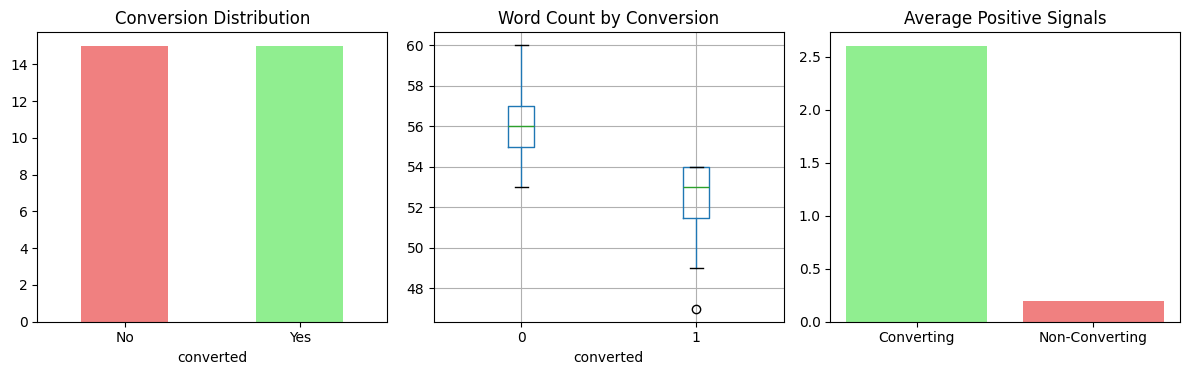

In [29]:
df = step2_explore_data(df)

In [30]:
base_embeddings, base_model = step3_create_embeddings(df)
base_embeddings,base_model

Generated embeddings: (30, 384)
Similarity between converting conversations: 0.610
Similarity between converting and non-converting: 0.568


(array([[-0.13712546,  0.00861407, -0.02162814, ...,  0.01608207,
         -0.01010634,  0.0657888 ],
        [-0.04510918, -0.01433305, -0.06398379, ..., -0.0787148 ,
         -0.03818011,  0.04579803],
        [-0.11377348,  0.03219131, -0.04186193, ...,  0.00953618,
         -0.00259409,  0.09527639],
        ...,
        [-0.06645596, -0.01645601, -0.00741733, ...,  0.02389577,
         -0.10602403, -0.03218288],
        [-0.08251361,  0.06963804, -0.07063784, ..., -0.03621007,
          0.04203331,  0.05397315],
        [-0.0907369 ,  0.06210662, -0.05910363, ..., -0.04817181,
          0.05055156,  0.03493002]], shape=(30, 384), dtype=float32),
 SentenceTransformer(
   (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
   (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean

In [31]:
baseline_classifier, baseline_accuracy = step4_basic_classifier(df, base_embeddings)

Generic embeddings accuracy: 100.0%

Classification Report:
               precision    recall  f1-score   support

Not Converted       1.00      1.00      1.00         5
    Converted       1.00      1.00      1.00         4

     accuracy                           1.00         9
    macro avg       1.00      1.00      1.00         9
 weighted avg       1.00      1.00      1.00         9



In [ ]:

# 
# fine_tuned_embeddings = step5_simulate_fine_tuning(df, base_model)
# fine_tuned_classifier, fine_tuned_accuracy = step6_evaluate_fine_tuned(df, fine_tuned_embeddings, baseline_accuracy)
# step7_prediction_demo(fine_tuned_classifier, df)
# step8_business_impact(baseline_accuracy, fine_tuned_accuracy)

# print("\nExperiment Complete!")
# print(f"Final Results: {baseline_accuracy:.1%} → {fine_tuned_accuracy:.1%} ({fine_tuned_accuracy-baseline_accuracy:+.1%})")

